In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

import gc

gc.collect()
torch.cuda.empty_cache()

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import GPT2Model
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
df = pd.read_csv("tweets.csv")
df.dropna(inplace=True)

tweets = df.tweets.copy()

# GPT has a convenient way to handle single column data
# using the beginning and end of string tokens
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
tweets

0                                              Surprise me
1        For example, Twitter could very conceivably sc...
2        Sort of ya, but whatever might answer the ques...
3        This exact problem is why we funded mRelief, t...
4                             People actually believe this
                               ...                        
25547      whoa there, you got a source on that one buddy?
25548    Yeah. WOULDNT surprise me she has someone lock...
25549    What good is identity? It can make you act irr...
25550    you don't have to "indoctrinate" people into b...
25551    It looks almost neoclassical honestly. I don’t...
Name: tweets, Length: 25552, dtype: object

In [5]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=526):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [6]:
dataset = GPT2Dataset(tweets, tokenizer, max_length=526)

In [7]:
# Split into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
train_size

20441

In [9]:
test_size

5111

In [10]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = 1
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = 1
        )

In [17]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# resizes input token embeddings matrix of the model
# so that the model matches the tokenized inputs
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [13]:
device = torch.device("cuda")
model.cuda()

seed_val = 47

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [14]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e3
epsilon = 1e-7

sample_every = 1000

In [16]:
optimizer = torch.optim.AdamW(
                    model.parameters(),
                    lr = learning_rate,
                    eps = epsilon
                )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
                                        optimizer, 
                                        num_warmup_steps = warmup_steps, 
                                        num_training_steps = total_steps
                                    )

In [16]:
training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            print('Batch {:>5,} of {:>5,}. Loss: {:>5,}.'.format(step, len(train_dataloader), batch_loss))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 280,
                                    top_p=0.99, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
        
    # Testing

    print("")
    print("Running Testing...")

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(test_dataloader)

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Testing Loss': avg_val_loss
        }
    )

print("")
print("Training complete!")



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000 of 20,441. Loss: 0.2672589123249054.
0:  rewardsIn a community where information about crimes is hard to identify, it can be tricky to tell whether the information has anything to say about it. But to not put it out and open it in the commons is to put it out and open it in the public hands.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000 of 20,441. Loss: 0.23278845846652985.
0: oonIt's also worth the mention, if you want to spend the week on a man they should do it, don't worry about the problem


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000 of 20,441. Loss: 0.27232059836387634.
0: ppyI swear there are not even words words here, just words of ideas with words around their respective objects


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 4,000 of 20,441. Loss: 0.5199285745620728.
0: niawho would sell them on some internet connection if she gets it on it?there is no need to prepare on purpose for a massive boom at the bottom, with big money and a cheap pump to get more buys?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 5,000 of 20,441. Loss: 0.42935094237327576.
0:  ShanI'm a good guess.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 6,000 of 20,441. Loss: 0.21982017159461975.
0:  ChanI've called it "the best" every person has the biggest amount of energy that they want to spend to spend to make it into real-world projects... "this new" to happen


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 7,000 of 20,441. Loss: 0.10704772174358368.
0:  veteranshe seems very certain, but I absolutely agree with that, that's true. What's it?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 8,000 of 20,441. Loss: 0.30919840931892395.
0:  Bi the a, itI IS and are’I the get,. be that they to this to the this who a as ( a for, be and A


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 9,000 of 20,441. Loss: 1.495906114578247.
0:  \(If to you, the in is the of is the I the do would that the that the for their that to the, in you are can you people I you can just. about. just it I really


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 10,000 of 20,441. Loss: 0.31290221214294434.
0: pringI'm not the good for a get I don't do are " He're an get use some are so you believe your'm do you're get is.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 11,000 of 20,441. Loss: 0.25677335262298584.
0: �"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 12,000 of 20,441. Loss: 0.3957837224006653.
0:  IndustriesFor "in the point are a lot about a point as a very full-as!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 13,000 of 20,441. Loss: 0.19431623816490173.
0:  skI have much right this, but that has a "bh. Is that, but to be an reason you have wrong because I'm wrong.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 14,000 of 20,441. Loss: 0.11335599422454834.
0: DurationT IS E ALL MION THE BE THE SOC ALL THE BOSE TO ARE THNAIALES IN THE NILL TO TO THE THENILY THEONGFTTH NO TH OF THE THIND ON TOION OF THE THTH OUT NO THE TO THE THREAD OUT THY ARE OF MORE OF THE PLINKEN YOU IN A BE THEN OF BE ALL ARE OF FFTS INY THE THREADREADY THED THONG ALL MOREURE OF THE ANIND THE ATHFTURE PEOPLE SHOULD SHOULD PEOPLE ALL THFTE THEREAD THEES THE OF TH THE YOUR YOUR THONG TOESILIAL OUT WITH SHOULD BEYENIND SHOULD ALLYINDIONENTY IN PEOPLEING TO TO MREADFT THFT ARE PEOPLE NO IN NOION ALL IN OF SHOULDURE ALL OF THIS PEOPLE ON THE THAT TO PEOPLE THFTIALEN THE THE THE THE A ON BEING PEOPLE TO SHOULD SHOULD BE IS THINKREADREAD OUT THS THE AONG ALL TO ALL OF THE THIND SHOULD TO SHOULD BFT TH SHOULD ON ON YOUR THE THINDIND THE BY THELF ALL THOSE THFT OUT TO THE THE MORE OF AREAD TOURE THE HY TO ON THION OF THE ON OF NIND THENT ALL OF E OF ARE THURFT TO TH IN ON TO IS THE YOU ON THE SHOULD TH TH OF IS ALL


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 15,000 of 20,441. Loss: 0.19041919708251953.
0: FixedI'd not a man was trying to have with the face that, a fucking way like if it was possible to the story.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 16,000 of 20,441. Loss: 0.2995605170726776.
0:  CreationWgt; He's even be very similar and I'm not genuinely even hard to be been not seen that being "hbrito" it. But they've said when you were wrong to be like more interesting and really hard to get a lot and the whole. They'll expect to be available


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 17,000 of 20,441. Loss: 0.0522315688431263.
0: athIt would not be a joke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 18,000 of 20,441. Loss: 0.6455888152122498.
0: imatelyyou want someone to keep a lot about a lot of sex by the only reason?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 19,000 of 20,441. Loss: 0.20341244339942932.
0: 6I have an open by people in particular. that's not completely even how it's completely the reason about people were the best thing


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 20,000 of 20,441. Loss: 0.284874826669693.
0: GenerED REMOUGH IMPITATIVE TECHKOVED ONNOVATION TAY OF ACCIPIPOTAL IS ABOUT IT TO FRES THALKS TORTIONS TO NEVER BE A CAIN HOW TO BE IT WAS IMPORT IN THIS REK

Running Testing...

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000 of 20,441. Loss: 0.11801905184984207.
0:  IPvAFAIK IS EGO TO BE, AFAIK in that the world needs to be near the future. It is bad to become more than the world would be a startup by being used to them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000 of 20,441. Loss: 0.17886687815189362.
0:  BecThis is how many people aren't good, but a thing I don't realize the most rich people want for it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000 of 20,441. Loss: 0.35760870575904846.
0:  SilvaI'd not have the first few times to have been given as a little different one. It's a 5% 2: if it's all the one of what will make the average less-5 years.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 4,000 of 20,441. Loss: 0.45202451944351196.
0: abi... I have to see what happens.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 5,000 of 20,441. Loss: 0.43238189816474915.
0:  lmao. my long as a good example, my life is worth. I'm very hard enough. I'd pay you for myself


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 6,000 of 20,441. Loss: 0.14558008313179016.
0: obyYeah I do not make them from what he'd or do that. what it shouldn't or for me to find at being used:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 7,000 of 20,441. Loss: 0.2723815143108368.
0:  marketedIt's just not a strong goal on twitter and twitter is a big.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 8,000 of 20,441. Loss: 0.23808027803897858.
0: cluded"the guy has since been talking about me (which made me* my last time with it". I would have to remember: I'd read this one couple times:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 9,000 of 20,441. Loss: 0.04897104576230049.
0:  simplerI'm not sure if I was going to use a game from PoW over by PoS. All the crypto isn't the PoS-of-of-based case, where PoS gets PoS isn't great, and to be the best hold that stuff. This creates.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 10,000 of 20,441. Loss: 0.12445640563964844.
0:  singerjust get on this.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 11,000 of 20,441. Loss: 0.08633144944906235.
0:  stretchIn general, this is why it is really a thing to do the fact that it's all not what I do, more people than it, but. All of them will say as well as I'm gonna think it's bad to see what a bunch of you understand what they do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 12,000 of 20,441. Loss: 0.2505572736263275.
0:  schemeYou can just be bad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 13,000 of 20,441. Loss: 0.06291641294956207.
0: patchThe people who make a good blue bar in the Bay Area


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 14,000 of 20,441. Loss: 0.12999327480793.
0:  liftingBirliant this will be a bit different.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 15,000 of 20,441. Loss: 0.5291248559951782.
0:  verifyIf you can't get me, and it's just a good problem where you mean "I get your views" etc


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 16,000 of 20,441. Loss: 0.30834126472473145.
0: onerI'm not on the bottom of these cultural norms, I think it's not a problem for other who are both the state. The state/the government/authoritarian, "un-lethal" is a small result of the real-waking (or/social economy) a "social" (which it never will be effectively to measure


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 17,000 of 20,441. Loss: 0.5315341353416443.
0:  wonderfulHe really does all the time-day, especially for the reason to have not been written by The West with the Wokeism and the West


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 18,000 of 20,441. Loss: 0.0542093850672245.
0:  cur"THE MARILOLI HATE TO THE USILVIRIDITY TO THE A COLER OF THE A LOT OF IT THEMS OF THE FONES, BUT TO BEINGING.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 19,000 of 20,441. Loss: 0.33549731969833374.
0:  administratorI also said that the best and most dangerous stuff on my left wing are people


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 20,000 of 20,441. Loss: 0.0999692976474762.
0: BMI also don’t think this as a normal problem.But I can also guess if everyone else doesn’t understand how to play around the rest. That would be very easy to decide whether.

Running Testing...

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000 of 20,441. Loss: 0.10445742309093475.
0:  NateIt's a sign because the data processing algorithm doesn't work for Bitcoin, but the algorithm that might be interesting, and they probably want to sell in a new name instead.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000 of 20,441. Loss: 0.35214027762413025.
0:  omittedIf you don't believe that it's already the way you're doing this


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000 of 20,441. Loss: 0.4850826561450958.
0:  HamiltonYeah, but not, I don’t. You’re a bad skil tbh but I only have it but to say that again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 4,000 of 20,441. Loss: 0.08823464065790176.
0: EverythingI think the main part I'm gonna be doing is to be able to take out and more easily with one and another startup in the past couple months.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 5,000 of 20,441. Loss: 0.0531083419919014.
0:  BeingIf there were people whose lives then the lives are also living in the West. There will have been a living in a land that is safe.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 6,000 of 20,441. Loss: 0.2003236711025238.
0:  HammerI do think we're not gonna build our own children. You want to be a middle class. You can tell him when you want two jobs. He doesn't matter, his parents don't really want to say. He doesn’t know why they hate our kids.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 7,000 of 20,441. Loss: 0.41771259903907776.
0:  nationallyThe only way to make an existence of the world it can do is that we do, as a result, we don't have in the world, it's like that. Or do you have to have to think of that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 8,000 of 20,441. Loss: 0.35600918531417847.
0:  �There are plenty of things you can look about who know about them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 9,000 of 20,441. Loss: 0.4626334309577942.
0: ergPeople think it's good that they may take more from the future, and the people who think that way.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 10,000 of 20,441. Loss: 0.14925092458724976.
0:  PolicyI read my own book on "I’m not gonna go straight by any third person" - "I am a bad person?" Well, that’s not good


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 11,000 of 20,441. Loss: 0.12202730029821396.
0: BodySounds like a good idea. There's no content. EACH.E.g.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 12,000 of 20,441. Loss: 0.41188961267471313.
0:  fatallyYou can help much if you're a "trained company, but if that’s a good thing, it must be a good move.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 13,000 of 20,441. Loss: 0.17764727771282196.
0: commentin most cases


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 14,000 of 20,441. Loss: 0.5035473704338074.
0: scope"The idea is that you don't share your account over the world"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 15,000 of 20,441. Loss: 0.5134050250053406.
0: 11Why would it be? I can be careful of what the first step you'd have on. The first rule in the next year: the first time you don't be a good leader, the second later, will still be the best and start these.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 16,000 of 20,441. Loss: 0.3272613286972046.
0:  placesThe one of your tweets are the first ones you have ever studied. I'm not sure why I've been in a different place. She had the first time. She was a single girl of mine too few minutes. The best friends were me, but mostly good and beautiful


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 17,000 of 20,441. Loss: 0.08804266899824142.
0: CONYes I'll dumpED TO A FINALLY FOCUTIONS AT THE CONSTANT. TO RINTURE, IF YOU WANT TO NOT TENICT TO FAKE ANYTHING.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 18,000 of 20,441. Loss: 0.09331559389829636.
0:  standardThe US has not had any interest in this tax-carrying it's "am I going to buy bitcoin again and pay my doodily" and it makes everyone want to pay for it. I think you can't be patient. I hope that's the situation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 19,000 of 20,441. Loss: 0.22895853221416473.
0: awksIt's possible for me to think. He's a better friend than a friend and an oldER. So even if he's just as lucky as he can get out!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 20,000 of 20,441. Loss: 0.2517152428627014.
0: otherapyI don't think I have to be able to escape. I think the most authority in the whole world isn't worth it.

Running Testing...

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000 of 20,441. Loss: 0.20223179459571838.
0: ighedIt's also not really like this but I remember hearing it, so definitely I know it. All I know is that the answer is as old as I'm aware of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000 of 20,441. Loss: 0.3506355881690979.
0:  ArmedI'm sure he'll find the opiate


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000 of 20,441. Loss: 0.04248211905360222.
0: AdditionalI think it does for me to be a straight white male m. She's also a racist. Also, I might have m8 to make an entire identity. I don't even consider hermit to say that to be the end of your political spectrum.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 4,000 of 20,441. Loss: 0.10224205255508423.
0:  JoanI'd be pleased to say that in the mirror


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 5,000 of 20,441. Loss: 0.09165028482675552.
0: regonno the only way i read it is what I want and what it makes, the other half I've worked hard and got a whole whole really really really really really really really really really really really really really really really really hard


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 6,000 of 20,441. Loss: 0.09084869921207428.
0:  biWhat? What do your worst tweets?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 7,000 of 20,441. Loss: 0.6148510575294495.
0: 205There's a real truth and there's nothing in play there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 8,000 of 20,441. Loss: 0.2329113483428955.
0: FranceMaybe Elon would start a DAO.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 9,000 of 20,441. Loss: 0.41456159949302673.
0:  abbreI had onlyfans on Twitter but I actually didn't look up until the post. Now this is a failure.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 10,000 of 20,441. Loss: 0.13136246800422668.
0: AmericanThere did not have access, including the NYT and was widely read by tech insiders. Look for your NYT and the press to find you to read it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 11,000 of 20,441. Loss: 0.5267097353935242.
0:  Solomon"We had to clarify the correction to this exchange for e-link, which we had to agree on."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 12,000 of 20,441. Loss: 0.31230175495147705.
0:  AppsIt was all very nice to have a conversation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 13,000 of 20,441. Loss: 0.06022137776017189.
0:  cumI disagree the point is that it's not that the right people hold it against me after the fact that I don't like him (stfu) and I'll also be wrong.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 14,000 of 20,441. Loss: 0.13118980824947357.
0:  Conservthey all use - they never use the word to quote the question


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 15,000 of 20,441. Loss: 0.1627255380153656.
0:  financingno don't worry. I said that was the first time I moved, the second shot. but if you were being there, you should get the explanation and then know your explanation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 16,000 of 20,441. Loss: 0.10917560756206512.
0:  HankThis is going on forever but honestly, I'm not going to. I don't think I should use DOGE against DOGEBULLch. That's a great way to pump out now. If anything on the books, they should have had to price a certain price for a given.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 17,000 of 20,441. Loss: 0.4675069749355316.
0: ianceWe must all stop people from having an ancient ancient... from ancient human nature, all of which was meant by some of those who lived in ancient empires, would beel slave in some primitive kind of broken ways?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 18,000 of 20,441. Loss: 0.04592578113079071.
0:  liabilitiesthe first real question is *this* sexual orientation. if you are more sexual, your sexual orientation will be legal


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 19,000 of 20,441. Loss: 0.03067287988960743.
0: ustersI'm not here to play this game for the people I don't live in, and I don't think we have bad expectations for that kind of thing, the lack of "good" ideas are good for the long-term.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 20,000 of 20,441. Loss: 0.10996535420417786.
0:  EAAnd as you can tell, there’s a good reason why the man isn’t able to find access for women. This isn’t something that happens. Just don’t make it explicit that your beliefs are impossible.

Running Testing...

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000 of 20,441. Loss: 0.343625545501709.
0:  wandIs that a real world thing? Imagineagine something different?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000 of 20,441. Loss: 0.10634515434503555.
0: alshYeah I went from there


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000 of 20,441. Loss: 0.06571092456579208.
0:  Forgotten“No duck ass”


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 4,000 of 20,441. Loss: 0.0752381682395935.
0: mic&gt; coinbase became widely available in 10 years.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 5,000 of 20,441. Loss: 0.11498396843671799.
0:  yen(and as we know, people actually are literally asking for themselves to do it)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 6,000 of 20,441. Loss: 0.10174445062875748.
0: elsenMy Twitter isn’t really enough


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 7,000 of 20,441. Loss: 0.18184253573417664.
0:  SergeantWhat’s the best “villa” We are living in the longs. The actual attempt to convince someone that the “ remembered bad is the enemy” of any old man and our supposed—is. And we’ve lost a wealth concentration of a war on our own...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 8,000 of 20,441. Loss: 0.05631910637021065.
0:  StillI was joking. I'd have to guess tbh. One more times before that, and since a few more times... still worth reading all the time, I've been chatting.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 9,000 of 20,441. Loss: 0.2148927003145218.
0: 377The average age study in this study is basically low.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 10,000 of 20,441. Loss: 0.4773012399673462.
0:  epidemic"It's true for insurance companies in the next disease"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 11,000 of 20,441. Loss: 0.08220940083265305.
0:  rememI don't even know who to give them probability, but I'm not sure what To*. I bet on the future of the 2020s once it's a baby.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 12,000 of 20,441. Loss: 0.04946780577301979.
0: ressingThe other problem with BTC is that the government bond itself has 0 lead, BITCOIN rate, technicality etc. And in current BTC I mean 50%. The real estate' dating is pretty much of a stock. I think people will have to give the benefit of the country.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 13,000 of 20,441. Loss: 0.2679298222064972.
0:  ChileThere would be a great opportunity if people had seen this one:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 14,000 of 20,441. Loss: 0.041833359748125076.
0:  verseI wonder if that's a big problem for the public spaces.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 15,000 of 20,441. Loss: 0.12855638563632965.
0:  15yes, it was, the worst.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 16,000 of 20,441. Loss: 0.19163575768470764.
0: VERTAnd you want something to say, I think it’s pretty well structured, and frankly, as you get to feel, it’s probably a good way to look obese for himself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 17,000 of 20,441. Loss: 0.08456148207187653.
0:  DigitalFor women, the best “gary” in the world is to put men in a detransition or a w/o full-time brookol. It’s never even true for people who don’t make everything work.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 18,000 of 20,441. Loss: 0.04118768870830536.
0:  revisionyes, that is how u feel


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 19,000 of 20,441. Loss: 0.24455484747886658.
0: umbledoreIt's like you meant. There's a very particular set of " moves" in the sense that there will be no real push for a reactionary narrative from behind this.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 20,000 of 20,441. Loss: 0.10838542133569717.
0:  PDFyes, i know you're still on the internet.

Running Testing...

Training complete!


In [17]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Testing Loss
epoch,,
1,0.31,0.30
2,0.28,0.27
3,0.24,0.27
4,0.20,0.27
5,0.15,0.28


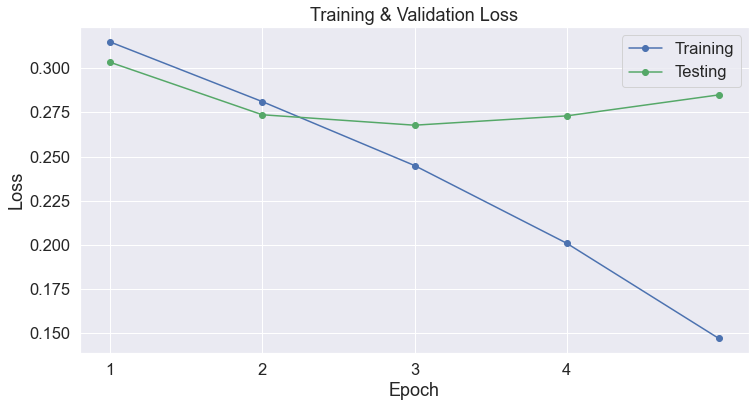

In [22]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# plot the learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Testing Loss'], 'g-o', label="Testing")

# plot labels
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [23]:
# get all of the model's parameters
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [24]:
output_dir = './model_save/'

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)s

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [18]:
tokenizer = GPT2Tokenizer.from_pretrained('./model_save/', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

In [19]:
configuration = GPT2Config.from_pretrained('./model_save/', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained('./model_save/')

model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [20]:
device = torch.device("cuda")
model.cuda()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [93]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,   
                                top_k=15, 
                                max_length = 280,
                                top_p=0.99, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i + 1, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
1: This is why I'm not pro death. I don't support death, I'm not saying that life has should be killed.I don't support death if it does. I'm alone, nobody would want to die.


2: I think this is actually an interesting situation. It's hard to find out precisely the optimal solution.


3: I've had no money to do this for a while now and I've been a latecomer since then I went back to look great.


4: I think that a lot of people would be better off seeing this than being honest with me. I think  is actually correct but also, importantly I believe you’re mistaken. I’re saying you’re wrong because you’re mistaken. Do you believe me?


5: Yes, the real reason values are good. But the real question is that "you can dollar-cost averaging into Bitcoin without running out of Ethereum!" coins that people will get better and more of that "you have a few."


